In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
# Switch to GPU if available for faster calculations
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")  # Use CUDA device
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('GPU not found, using CPU instead.')

Using GPU: NVIDIA GeForce MX230


In [4]:
from elo_ai.helper_functions import load_dataset
from elo_ai.helper_functions import elo_range

from elo_ai.models import complex_network
from elo_ai.models import train_network

In [5]:
rating_ranges = elo_range.get_rating_ranges()

### Load Analyzed Games

In [6]:
position_type = "boards_mirrors"
path = "../../../datasets/"
dataset = load_dataset.load_games(position_type, path)
print("Total Games:", len(dataset))

Total Games: 20000


In [7]:
def modify_dataset(dataset):
    import random

    random.shuffle(dataset)

    total_games = len(dataset)
    test_games = int(total_games * 0.15)

    x_train =[(position.to(device), evaluation.to(device)) for position, evaluation, _ in dataset[:-test_games]]
    y_train = [elo_range.calculate_rating_ranges(elo).to(device)
               for _, _, elo in dataset[:-test_games]]
    x_test =[(position.to(device), evaluation.to(device)) for position, evaluation, _ in dataset[-test_games:]]
    y_test = [elo for _, _, elo in dataset[-test_games:]]
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = modify_dataset(dataset)

In [8]:
print("Train Games:", len(x_train))
print(x_train[0][0].shape)
print(x_train[0][1].shape)

Train Games: 17000
torch.Size([2, 66, 2, 8, 8])
torch.Size([2, 66, 17])


### Define the Model

In [9]:
def create_model():
    input_size = x_train[0][1].shape[-1]
    channels = x_train[0][0].shape[-3]
    lstm_model = complex_network.EloGuesser(input_size, input_channels=channels, num_classes=rating_ranges.shape[0])
    learning_rate = 0.0001
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
    
    return lstm_model, optimizer

lstm_model, optimizer = create_model()

In [10]:
input_size = x_train[0][1].shape[-1]
channels = x_train[0][0].shape[-3]
print(input_size, channels)

17 2


### Train the model

In [11]:
loss_graph = []

In [ ]:
# The Kullback-Leibler Divergence (KLDivLoss) is used because it measures the divergence between two probability distributions
# in this case, the modeled normal distribution of the player's true Elo and the predicted distribution of the model.
loss_func = torch.nn.KLDivLoss(reduction='batchmean')

loss_graph += train_network.train(lstm_model, x_train, y_train, optimizer, loss_func, num_epochs=20, validation_split=0.10)

In [11]:
# If it was already trained previously, load the trained parameters
lstm_model.load_state_dict(torch.load(f"{position_type}.pt"))

<All keys matched successfully>

In [12]:
# To free CUDA memory
del x_train, y_train

### Plot the results

In [12]:
from elo_ai.helper_functions import plot_results

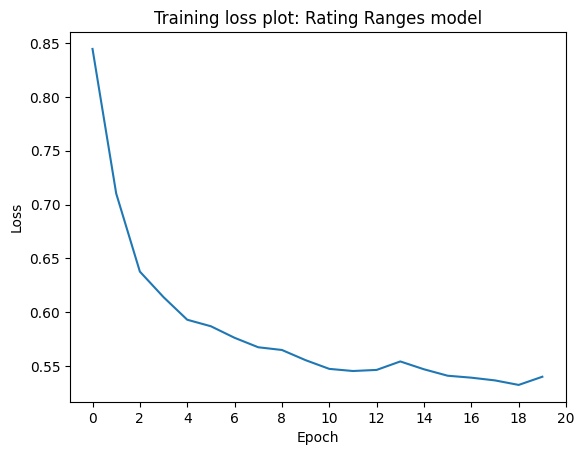

In [39]:
plot_results.plot_loss(loss_graph)

### Test predictions

In [20]:
def get_predictions(lstm_model, x_test):
    predictions = []
    for game in x_test:
        model_prediction, (_h, _c) = lstm_model.eval()(game)
        elo_prediction = elo_range.guess_elo_from_range(model_prediction).cpu().detach()
        predictions.append(elo_prediction)
    return predictions

predictions = get_predictions(lstm_model, x_test)

In [22]:
# Flatten the output vectors
predictions = torch.cat(predictions).view(-1)

In [15]:
y_test = torch.cat(y_test).view(-1)

Mean error: 219.15199279785156
50th percentile: 178.877197265625
90th percentile: 454.6348876953125


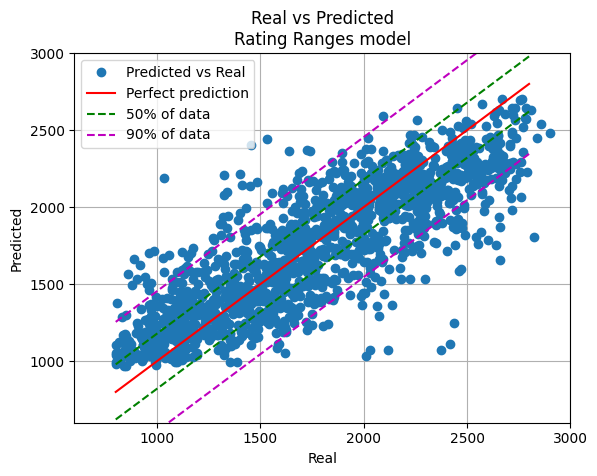

In [23]:
plot_results.compare_results(predictions, y_test)

In [24]:
def rate_predictions(predictions, y_test, leeway):
    predictions = elo_range.round_elo(predictions)
    y_test = elo_range.round_elo(y_test)
    difference = torch.abs(predictions - y_test)
    correct = (difference <= leeway).sum()

    return correct.item() / len(predictions)


stdev = 200
standard_deviations = [i * stdev for i in range(1, 4)]
for i, leeway in enumerate(standard_deviations):
    correct_percentage = rate_predictions(predictions, y_test, leeway)
    print(f"{i+1} standard deviations: {correct_percentage:.3f}")

1 standard deviations: 0.605
2 standard deviations: 0.877
3 standard deviations: 0.966


In [ ]:
# If the results are acceptable, save the model
torch.save(lstm_model.state_dict(), f"temp/{position_type}.pt")